In [2]:
%matplotlib inline
import numpy as np
import os
import scipy
from sklearn import manifold
import torch
from torch import nn

from models import flow_transforms, flow_likelihood#, flow_pipeline
from models import torch_models
from synthetic import flow_toy_data
from utils import utils, torch_utils

import matplotlib.pyplot as plt

import IPython


def default_nn_config():
  input_size = 10  # Computed online
  output_size = 10  # Computed online
  layer_units = [32, 64]
  use_vae = False
  activation = nn.ReLU  # nn.functional.relu
  last_activation = torch_models.Identity  # functional.sigmoid
  # layer_types = None
  # layer_args = None
  bias = True
  dropout_p = 0.
  layer_types, layer_args = torch_utils.generate_linear_types_args(
        input_size, layer_units, output_size, bias)
  nn_config = torch_models.MNNConfig(
      input_size=input_size, output_size=output_size, layer_types=layer_types,
      layer_args=layer_args, activation=activation,
      last_activation=last_activation, dropout_p=dropout_p, use_vae=use_vae)
  return nn_config


def default_tfm_config(tfm_type="shift_scale_coupling"):
  neg_slope = 0.1
  scale_config = default_nn_config()
  scale_config.last_activation = torch.nn.Tanh
  shift_config = default_nn_config()
  shift_config.last_activation = torch.nn.Sigmoid
  shared_wts = False

  ltfm_config = default_nn_config()
  bias_config = default_nn_config()

  has_bias = True

  base_dist = "gaussian"
  reg_coeff = 0.
  lr = 1e-3
  batch_size = 50
  max_iters = 1000

  stopping_eps = 1e-5
  num_stopping_iter = 1000

  grad_clip = 2.

  verbose = True

  config = flow_transforms.TfmConfig(
      tfm_type=tfm_type, neg_slope=neg_slope, scale_config=scale_config,
      shift_config=shift_config, shared_wts=shared_wts, ltfm_config=ltfm_config,
      bias_config=bias_config, has_bias=has_bias, reg_coeff=reg_coeff,
      base_dist=base_dist, lr=lr, batch_size=batch_size, max_iters=max_iters,
      stopping_eps=stopping_eps, num_stopping_iter=num_stopping_iter,
      grad_clip=grad_clip, verbose=verbose)
  return config


def default_likelihood_config(args):
  model_type = "linear_arm"
  n_components = args.n_components
  dist_type = args.dist_type

  hidden_size = 32
  theta_nn_config = default_nn_config()
  theta_nn_config.last_activation = torch.nn.Tanh
  cell_type = "LSTM"  # not needed for linear_arm

  verbose = True

  config = flow_likelihood.ARMMConfig(
      model_type=model_type, dist_type=dist_type, n_components=n_components,
      hidden_size=hidden_size, theta_nn_config=theta_nn_config,
      cell_type=cell_type, verbose=verbose)

  return config


def default_pipeline_config():
  pass


def make_default_data(args, split=False):
  tfm_types = [ "linear"]
  if args.dtype == "single_dim_copy":
    Z = np.concatenate([np.random.randn(args.npts, 1)] * args.ndim, axis=1)
    scale = 5.
    scale_mat = np.eye(args.ndim) * scale
    X = Z.dot(scale_mat)
    tfm_args = []
  else:
    Z, X, tfm_args = flow_toy_data.simple_transform_data(
        args.npts, args.ndim, tfm_types)

  if split:
    split_frac = [0.8, 0.2]
    (tr_Z, te_Z), inds = utils.split_data(Z, split_frac, get_inds=True)
    tr_X, te_X = [X[idx] for idx in inds]

    return (tr_Z, te_Z), (tr_X, te_X), tfm_args
  return Z, X, tfm_args


def make_default_data_X(args, split=False, normalize_scale=None):
  # Z, X, tfm_args = flow_toy_data.simple_transform_data(
  #     args.npts, args.ndim, tfm_types)  
  X = np.random.randn(args.npts, args.ndim)
  if normalize_scale is not None:
    X_norm = np.linalg.norm(X, axis=1).reshape(-1, 1)
    X = X / X_norm * normalize_scale

  if split:
    split_frac = [0.8, 0.2]
    tr_X, te_X = utils.split_data(X, split_frac, get_inds=False)
    return tr_X, te_X
  return X


def make_default_tfm(args, tfm_args=[]):
  dim = args.ndim
  num_ss_tfm = args.num_ss_tfm
  num_lin_tfm = args.num_lin_tfm
  use_leaky_relu = args.use_leaky_relu
  use_reverse = args.use_reverse

  # Generate config list:
  tfm_configs = []
  tfm_inits = []

  #################################################
  # Bit-mask couple transform
  tfm_idx = 0
  idx_args = tfm_args[tfm_idx] if tfm_idx < len(tfm_args) else None
  if idx_args is not None and idx_args[0] == "scaleshift":
    bit_mask = idx_args[1]

  for i in range(num_ss_tfm):
    scale_shift_tfm_config = default_tfm_config("scale_shift_coupling")
    tfm_configs.append(scale_shift_tfm_config)
    if idx_args is not None and idx_args[0] == "scaleshift":
      bit_mask = 1 - bit_mask
    else:
      bit_mask = np.zeros(dim)
      bit_mask[np.random.permutation(dim)[:dim//2]] = 1
    tfm_inits.append((bit_mask,))

  # Fixed linear transform
  tfm_idx = 1
  # L, U = tfm_args[tfm_idx][1:]
  # _, Li, Ui = scipy.linalg.lu(np.linalg.inv(L.dot(U)))
  # init_mat = np.tril(Li, -1) + np.triu(Ui, 0)
  # eps = 1e-1
  # noise = np.random.randn(*init_mat.shape) * eps
  for i in range(num_lin_tfm):
    linear_tfm_config = default_tfm_config("fixed_linear")
    linear_tfm_config.has_bias = False
    tfm_configs.append(linear_tfm_config)
    tfm_inits.append((dim,))# init_mat))

  # # Leaky ReLU
  tfm_idx = 2
  if use_leaky_relu:
    leaky_relu_config = default_tfm_config("leaky_relu")
    leaky_relu_config.neg_slope = 0.1
    tfm_configs.append(leaky_relu_config)
    tfm_inits.append(None)

  # Reverse
  tfm_idx = 3
  if use_reverse:
    reverse_config = default_tfm_config("reverse")
    tfm_configs.append(reverse_config)
    tfm_inits.append(None)
  #################################################
  comp_config = default_tfm_config("composition")
  model = flow_transforms.make_transform(tfm_configs, tfm_inits, comp_config)

  return model


def make_default_likelihood_model(args):
  if not args.use_ar:
    return None
  config = default_likelihood_config(args)
  model = flow_likelihood.make_likelihood_model(config)
  model.initialize(args.ndim)

  return model



In [3]:
class args:
  etype = 1
  dtype = 1
  npts = 1000
  ndim = 10
  max_iters = 50000
  num_ss_tfm = 1
  num_lin_tfm = 1
  use_leaky_relu = False
  use_reverse = False
  dist_type = "gaussian"
  use_ar = False
  n_components = 5



In [5]:
# (tr_Z, te_Z), (tr_X, te_X), tfm_args = make_default_data(
#     args, split=True, normalize_scale=5)
nscale = 50.
tr_X, te_X = make_default_data_X(args, split=True, normalize_scale=nscale)
model = make_default_tfm(args, tfm_args=[])
lhood_model = make_default_likelihood_model(args)

config = model.config
config.batch_size = 1000
config.lr = 1e-4
config.reg_coeff = 0.1
config.max_iters = args.max_iters
config.stopping_eps = 1e-8

In [6]:
model.fit(tr_X, lhood_model=lhood_model)


Iteration 50000 out of 50000 (in 0.01s). Loss: 41.49175. Avg grad: 0.00005.Stop iter: 02. Stop iter: 0200
Training finished in 305.30 s.


CompositionTransform(
  (_tfm_list): ModuleList(
    (0): ScaleShiftCouplingTransform(
      (_scale_tfm): MultiLayerNN(
        (dropout): Dropout(p=0.0)
        (_logvar): Zeros()
        (_layer_op): Sequential(
          (0): Linear(in_features=5, out_features=32, bias=True)
          (1): ReLU()
          (2): Linear(in_features=32, out_features=64, bias=True)
          (3): ReLU()
        )
        (_mu): Linear(in_features=64, out_features=5, bias=True)
        (_last_activation): Tanh()
      )
      (_shift_tfm): MultiLayerNN(
        (dropout): Dropout(p=0.0)
        (_logvar): Zeros()
        (_layer_op): Sequential(
          (0): Linear(in_features=5, out_features=32, bias=True)
          (1): ReLU()
          (2): Linear(in_features=32, out_features=64, bias=True)
          (3): ReLU()
        )
        (_mu): Linear(in_features=64, out_features=5, bias=True)
        (_last_activation): Sigmoid()
      )
    )
    (1): FixedLinearTransformation()
  )
)

In [9]:
tr_Z_pred = model(tr_X, False, False)
te_Z_pred = model(te_X, False, False)
tr_Zinv_pred = model.inverse(tr_Z_pred, False)
te_Zinv_pred = model.inverse(te_Z_pred, False)

In [23]:
n_test_samples = args.npts // 2
# samples = model.sample(n_test_samples, inverted=False, rtn_torch=False)
samples = torch_utils.torch_to_numpy(model.base_dist.sample((n_test_samples, )))

In [24]:
# samples = np.concatenate(
#     [np.random.randn(n_test_samples, 1)] * args.ndim, axis=1)
X_samples = model.inverse(samples, rtn_torch=False)
X_all = np.r_[tr_X, te_X, X_samples]
Z_all = np.r_[tr_Z_pred, te_Z_pred, samples]
Zinv_all = np.r_[tr_Zinv_pred, te_Zinv_pred, X_samples]

In [ ]:
tsne = manifold.TSNE(2)
y_x = tsne.fit_transform(X_all)
y_z = tsne.fit_transform(Z_all)
y_zi = tsne.fit_transform(Zinv_all)

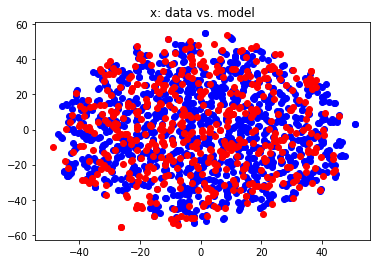

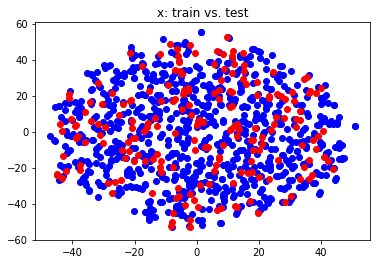

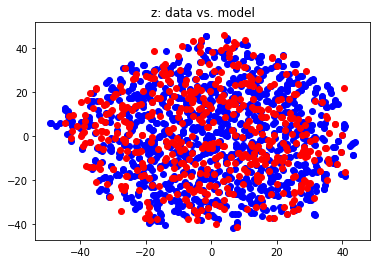

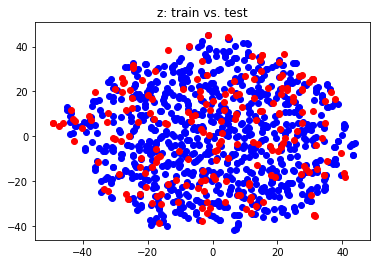

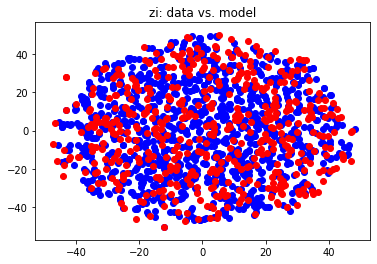

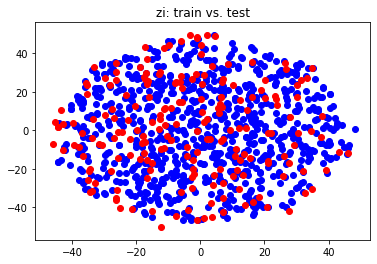

In [27]:
plot_data = {"x": y_x, "z": y_z, "zi": y_zi}

for pdtype, y in plot_data.items():
    plt.scatter(y[:args.npts, 0], y[:args.npts, 1], color="b")
    plt.scatter(y[args.npts:, 0], y[args.npts:, 1], color="r")
    plt.title(pdtype + ": data vs. model")
    plt.show()

    plt.scatter(y[:tr_X.shape[0], 0], y[:tr_X.shape[0], 1], color="b")
    plt.scatter(y[tr_X.shape[0]:args.npts, 0], y[tr_X.shape[0]:args.npts, 1], color="r")
    plt.title(pdtype + ": train vs. test")
    plt.show()